# Explore the house prices dataset with empirical copulas

We load the `house_prices` data set from OpenML and investigate the dependency between overall quality score and house price.



In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from empirical_copula import (
    empirical_joint_pmf_details,
    empirical_marginal_pmf,
    independent_pmf,
    joint_counts,
    order_pmf,
)
from empirical_copula.plot import (
    copula_pcolormesh,
    significance_copula_pcolormesh,
)
from empirical_copula.significance import significance_from_bootstrap

# Load the dataset

In [2]:
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True)
housing['data'].columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Create a DataFrame with the two variables we want to investigate

We select the feature `OverallQual` and the target house price, and discretize the house price in ranges of $25k each.

In [3]:
price_bins = np.arange(25000, 350000, 25000).tolist() + [1000000]
samples = pd.DataFrame(
    [
        housing['data']['OverallQual'].astype(int), 
        pd.cut(housing['target'], price_bins)
    ],
     index=['Rooms', 'Price']
).T
samples.head()

,Rooms,Price
0,7,"(200000, 225000]"
1,6,"(175000, 200000]"
2,7,"(200000, 225000]"
3,7,"(125000, 150000]"
4,8,"(225000, 250000]"


# Compute the marginal and joint distribution

In [4]:
pmf1, pmf2, empirical_pmf, others = empirical_joint_pmf_details(samples)

# In this case, both variables are ordinal, se we order them by their value (as opposed to their frequency).
pmf1 = order_pmf(pmf1, is_ordinal=True)
pmf2 = order_pmf(pmf2, is_ordinal=True)

Plotting the empirical joint distribution as a heatmap, we can see a dependency between two variables. However, it is unclear the exact nature of this relationship, since it is confounded by the frequency with which each pair occurs.

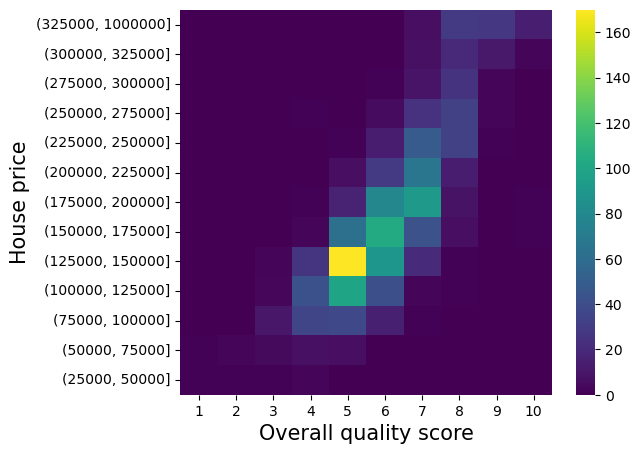

In [5]:
with plt.rc_context({'figure.figsize': (6, 5)}):
    ax = sns.heatmap(others['counts'].loc[pmf1.index, pmf2.index].T, cmap='viridis', vmin=0)
    ax.invert_yaxis()
    plt.xlabel('Overall quality score', fontsize=15)
    plt.ylabel('House price', fontsize=15)

To get a better idea of the dependencies, we can compare the heatmap above with the joint distribution one would expect if the two variables were independent.

As you can see below, the strong correlation between a quality score of `5` and the house price of `$125k-$150k` is expected just by the fact that these are the most frequent categories. Apart from that, there is clearly a strong general deviation from independence that we can investigate in more details using copulas.

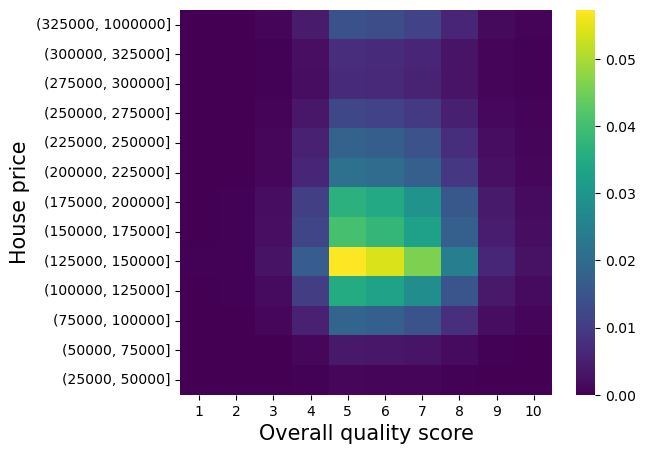

In [6]:
# Expected joint pmf if the two variables were independent
with plt.rc_context({'figure.figsize': (6, 5)}):
    ax = sns.heatmap(others['ind_pmf'].loc[pmf1.index, pmf2.index].T, cmap='viridis', vmin=0)
    ax.invert_yaxis()
    plt.xlabel('Overall quality score', fontsize=15)
    plt.ylabel('House price', fontsize=15)


# Visualize the empirical copula

Independent variables would have an empirical copula with a uniform value of 1.0 . 

We visualize the log10 of the observed copula values. The interpretation of this number is the log of the factor with which a given combination of values is observed compared to the expectation under the hypothesis of independence. For instance, a value of 0.5 in the plot below means that that combination of values appears 10^0.5 = 3.2 times more often than expected if the variables were independent.

In [7]:
diff_from_uniform = np.log10(empirical_pmf.replace(0, 1))

The empirical copula visualized below confirms that there are strong dependencies between overall quality and house price.

The dependency is particularly strong on the tails: for the most frequent quality score categories 5 to 7 average house prices are observed with frequency 2x to 3x the one expected assuming independence. The extreme high and low quality value, while observed less frequently, are associated with extreme high / low house prices with frequency over 10x the independent frequency.

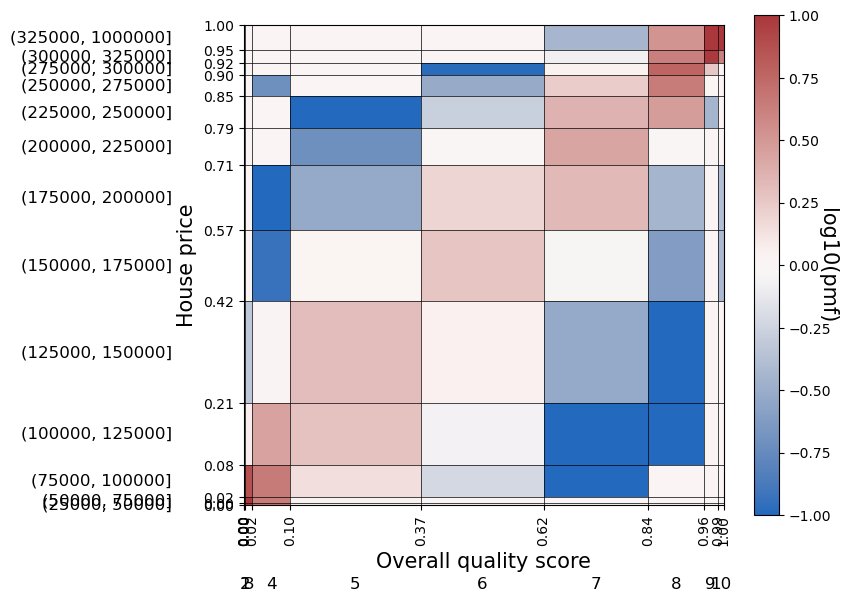

In [8]:
grid_lw = 0.5
max_diff_color = 1

with plt.rc_context({'figure.figsize': (6, 5)}):
    fig = plt.gcf()
    ax, pcm = copula_pcolormesh(fig, pmf1, pmf2, diff_from_uniform, grid_lw=grid_lw, 
                                vmin=-max_diff_color, vmax=max_diff_color, cmap='vlag', annotation_fontsize=12)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label('log10(pmf)', fontsize=15, rotation=270)
    plt.xlabel('Overall quality score', fontsize=15)
    plt.ylabel('House price', fontsize=15)

# Which of the observed deviations from independence are significant?

Are the strong dependencies observed in the tail statistically significant, or are they just noise due to the small sample site for those combination of values?

We can destroy the dependencies between the variables by resampling them replacement independently from each other. Doing this many times gives us an estimate of the distribution of the frequencies we would observe with the same marginal distribution if the variables were independent. We can then look at how extreme what we observe is compared to this 0-hypothesis distribution and derive a significance level.

In [9]:
random_state = np.random.RandomState(9393)
quantile_levels, quantile_levels_labels, significance = significance_from_bootstrap(
    samples, n_bootstraps=1000, p_levels_low=[0.001, 0.01, 0.05, 0.1], random_state=random_state)

The significance plot confirms that the observed dependencies are highly significant.

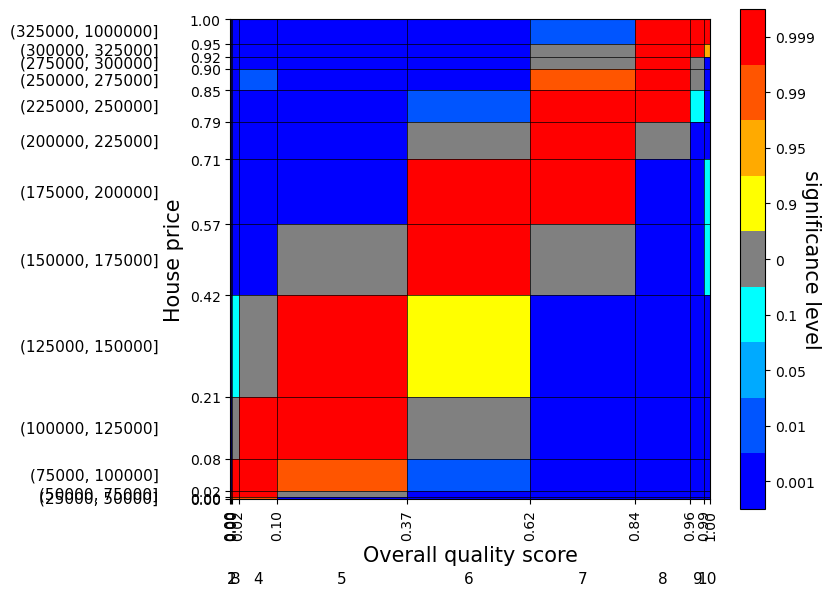

In [10]:
with plt.rc_context({'figure.figsize': (6, 5)}):
    fig = plt.gcf()
    significance_copula_pcolormesh(fig, pmf1, pmf2, significance, quantile_levels, grid_lw=grid_lw, annotation_fontsize=11)
    plt.xlabel('Overall quality score', fontsize=15)
    plt.ylabel('House price', fontsize=15)